# Задача 2. Линейная регрессия, метод градиентного спуска

Чижов Антон 23.М04-мм

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [x] Повторить то же самое, но используя **кросс-валидацию**.
- [x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [x] * (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [x] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [x] * (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [x] * (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

In [155]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, GridSearchCV, cross_validate)
from sklearn.utils import (gen_batches, shuffle)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


## Обобщенная реализация градиентного спуска

In [156]:
def batch_gradient_descent(model, X, y, lr, l2_coef, grad_clip_thr, update_lr, epochs, batch_size, eps):
    # a function that generalizes regular, stochastic and mini batch gradient descents

    np.random.seed(42)

    def clip_grad(grad):
        if grad_clip_thr:
            np.clip(grad, -grad_clip_thr, grad_clip_thr, out=grad)

    for _ in range(epochs):
        for batch_slice in shuffle(list(gen_batches(len(X), batch_size))):
            preds = model.predict(X[batch_slice])
            error = preds - y[batch_slice]

            n_features = len(model.coef_)
            grad = np.zeros((n_features, 1))
            for i in range(n_features):
                L2 = 2 * model.coef_[i] / n_features
                n_samples = len(X)
                grad[i] += (2 / n_samples * error.T @ X[batch_slice, i]).item() + l2_coef * L2
            clip_grad(grad)

            model.coef_ -= lr * grad
            if update_lr:
                lr = update_lr(lr)


## Линейная регрессия 

In [157]:
class Model:
    # linear regression (uses a similar interface to scikit's estimators)

    def __init__(self, method="gd", lr=1e-3, l2_coef=0, max_iters=100, update_lr=None, epochs=100, batch_size=10, grad_clip_thr=None, eps=None):
        self.method = method
        self.lr = lr
        self.l2_coef = l2_coef
        self.max_iters = max_iters
        self.update_lr = update_lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.grad_clip_thr = grad_clip_thr
        self.eps = eps

    def predict(self, X):
        return np.array(X @ self.coef_)

    def fit(self, X, y):
        # Here the batch_gradient_descent parameters change depending on the method.
        # If this is a regular gd, then the batch is equal to the entire dataset,
        # and if this is a stochastic gd, then the batch is equal to one.

        # this method highlights those parameters that are common to all methods
        def refined_batch_gradient_descent(epochs, batch_size):
            batch_gradient_descent(self, X, y, lr=self.lr, l2_coef=self.l2_coef, grad_clip_thr=self.grad_clip_thr, update_lr=self.update_lr, epochs=epochs, batch_size=batch_size, eps=self.eps)

        np.random.seed(42)
        n_features = X.shape[1]
        self.coef_ = np.random.normal(0, n_features * 2, (n_features, 1))
        match self.method:
            case "gd":
                refined_batch_gradient_descent(epochs=self.max_iters, batch_size=len(X))
            case "bgd":
                refined_batch_gradient_descent(epochs=self.epochs, batch_size=self.batch_size)
            case "sgd":
                refined_batch_gradient_descent(epochs=self.epochs, batch_size=1)
            case _:
                raise Exception(f"No such method '{self.method}'")

    def get_params(self, deep=True):
        return {"grad_clip_thr": self.grad_clip_thr, "method": self.method, "lr": self.lr,
                "l2_coef": self.l2_coef, "max_iters": self.max_iters, "update_lr": self.update_lr,
                "epochs": self.epochs, "batch_size": self.batch_size, "eps": self.eps}

    def set_params(self, **parameters):
        for key, value in parameters.items():
            self.__dict__[key] = value
        return self

    def score(self, X, y):
        # R^2
        preds = self.predict(X)
        return 1 - np.square(y - preds).sum() / np.square(y - np.mean(y)).sum()



***
## Описание датасета
Датасет California Housing Prices взят с сайта kaggle
https://www.kaggle.com/datasets/camnugent/california-housing-prices

В датасете представленны данные о калифорнийских микрорайонах (census block)
https://en.wikipedia.org/wiki/Census_block

- housingMedianAge - медианный возраст домов в микрорайоне 
- totalRooms - общее число помещений (комнат) в микрорайоне
- totalBedrooms - общее число спальных комнат в микрорайоне
- population - население микрорайона
- households - число домохозяйств в микрорайоне
- medianIncome - медианный доход в микрорайоне
- medianHouseValue - медианная цена дома в микрорайоне
- oceanProximity - близость к океану
- longitude - долгота
- latitude - широта

Мы будем проводить прогнозирование средней стоимости дома (**medianHouseValue**) в данном районе на основе остальных характеристик.


In [158]:
df = pd.read_csv("data/housing.csv")
df.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Отметим, что отсутствующие значения присутствуют только в категории числа спален.
Мы можем предположить наличие корреляции между общим числом комнат и количеством спален. Если это подтвердится, то, возможно, мы сможем избежать заполнения пропущенных значений, а просто исключить данный признак.

In [159]:
print(set(df["ocean_proximity"]))
df = df.replace({"ocean_proximity": {'<1H OCEAN': 1, 'INLAND': 0, 'ISLAND': 1, 'NEAR BAY': 2, 'NEAR OCEAN': 2}})


{'INLAND', 'NEAR BAY', 'ISLAND', 'NEAR OCEAN', '<1H OCEAN'}


Преобразум признак **ocean_proximity**. В нём есть пять категорий, которые указывают на расстояние до океана.\
 Преобразуем его в порядковый, где большее число будет означать меньшее расстояние до океана.

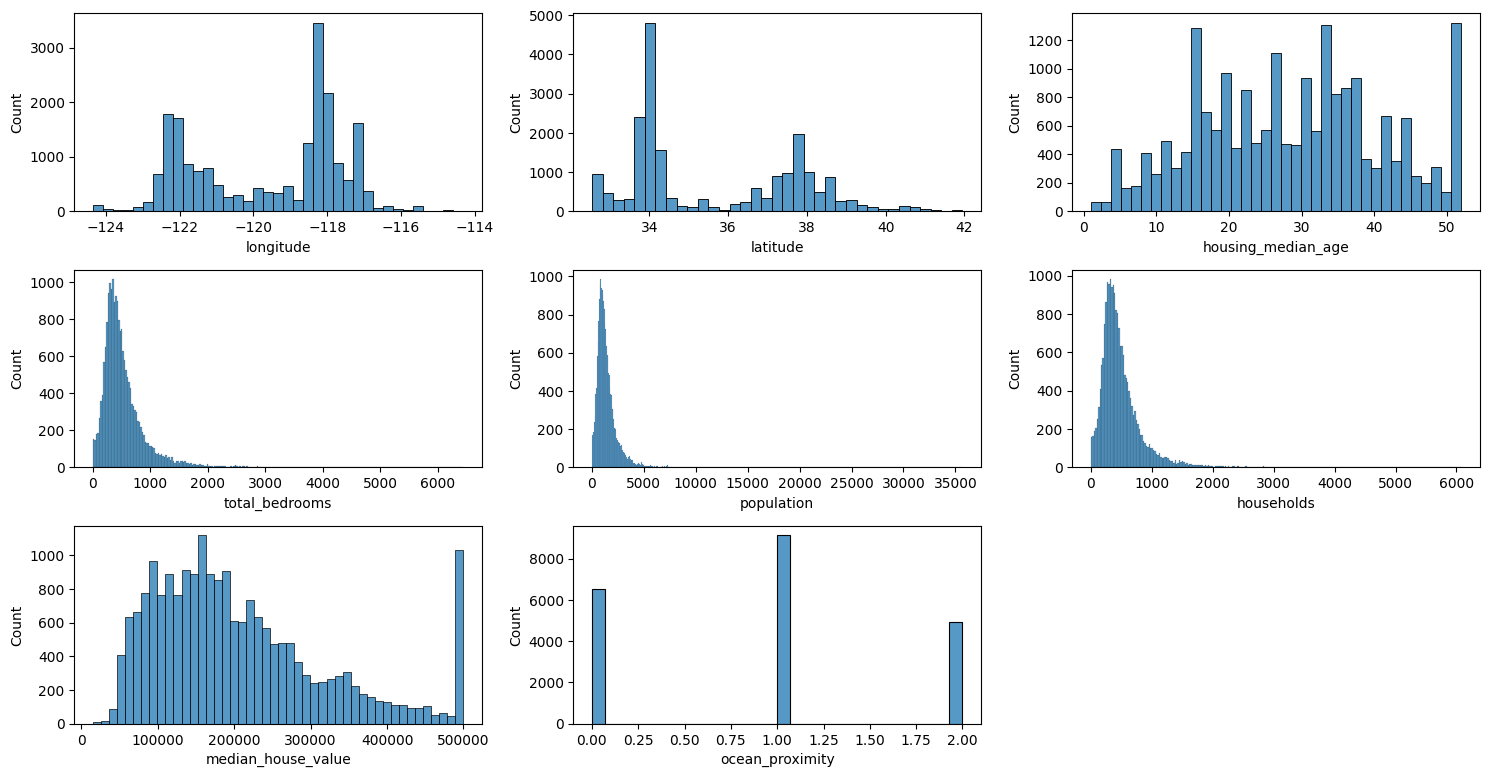

In [160]:
width = 3
height = 4

fig = plt.figure(figsize=(15, 10), tight_layout=True)
grid = fig.add_gridspec(height, width)
for i in range(height):
    for j in range(width):
        if i * height + j >= 10:
            break
        sns.histplot(df[df.columns[height * i + j]], ax=fig.add_subplot(grid[i, j]))


Для **median_house_value** видно большое количество домов, у которых очень большая стоимость.

<Axes: xlabel='median_house_value', ylabel='Count'>

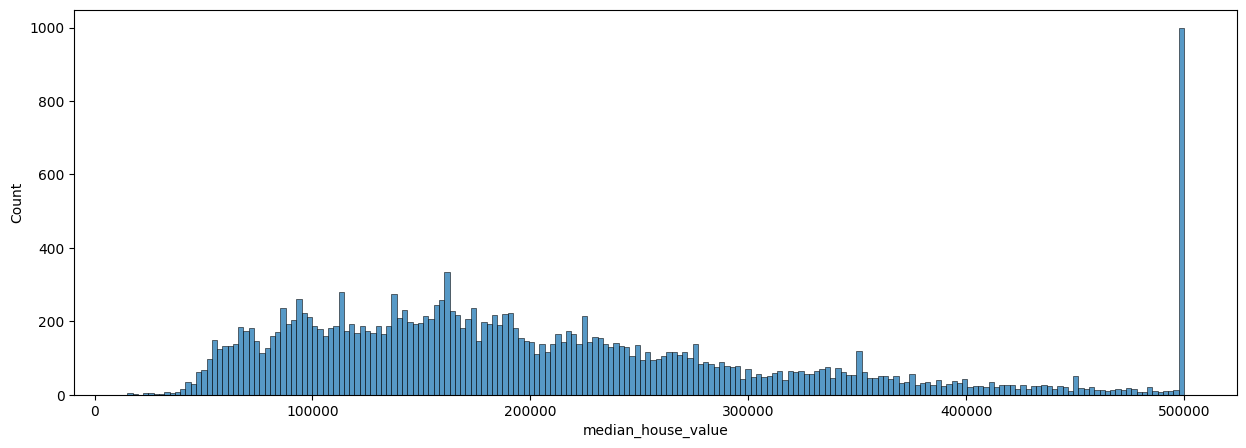

In [161]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(df["median_house_value"], bins=200)


In [162]:
df.nlargest(100, "median_house_value")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,2
459,-122.25,37.87,52.0,609.0,236.0,1349.0,250.0,1.1696,500001.0,2
493,-122.24,37.86,52.0,1668.0,225.0,517.0,214.0,7.8521,500001.0,2
494,-122.24,37.85,52.0,3726.0,474.0,1366.0,496.0,9.3959,500001.0,2
509,-122.23,37.83,52.0,2990.0,379.0,947.0,361.0,7.8772,500001.0,2
...,...,...,...,...,...,...,...,...,...,...
4559,-118.26,34.05,52.0,58.0,52.0,41.0,27.0,4.0972,500001.0,1
4603,-118.32,34.07,52.0,2156.0,306.0,861.0,311.0,8.8062,500001.0,1
4604,-118.33,34.06,52.0,1841.0,240.0,693.0,218.0,15.0001,500001.0,1
4605,-118.33,34.07,52.0,2248.0,255.0,813.0,265.0,15.0001,500001.0,1


Отдельно видно, что у очень большого числа микрорайонов одинаковая медианная стоимость домов 500001.0, скорее всего это ошибки в данных. 

In [163]:
len(df[df["median_house_value"] == 500001.0]) / len(df)


 0.0468

Относительно общего числа примеров, таких домов не очень много, можно от них избавиться.

In [164]:
df = df[df["median_house_value"] != 500001.0]


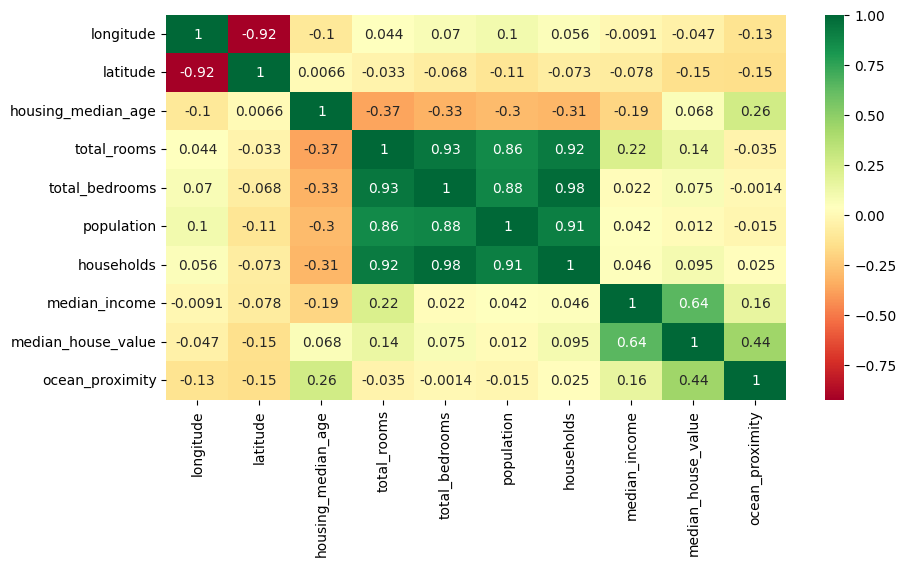

In [165]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


Видно сильную корреляцию между числом спален и комнат. Значит можно без особых потерь выкинуть признак с числом спален. 

Выделим возможный список значимых признаков: **ocean_proximity**, **median_income**, **total_rooms**, **housing_meadian_age** и **latitude**.

***

## Масштабирование и подготовка для обучения

In [166]:
scaler = StandardScaler(copy=False)

# add an additional "feature" to simplify the algorithm
df["bias"] = np.ones(len(df))

y = df["median_house_value"].to_numpy()
y = np.expand_dims(y, axis=1)

# getting rid of the target attribute and number of bedrooms
X = df.copy().drop(["median_house_value", "total_bedrooms"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler.fit_transform(X_train)
scaler.transform(X_test)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


## Выбор наилучшего подмножества признаков

In [167]:
from sklearn.feature_selection import RFECV

model = Model(max_iters=10000, lr=100, l2_coef=0.5, grad_clip_thr=50, method="gd", update_lr=lambda x: x*0.999)
rfecv = RFECV(model, cv=5, n_jobs=5).fit(X_train, y_train)

{ "support": rfecv.support_, "ranking" : rfecv.ranking_}


{'support': array([False, False, False, False,  True,  True,  True,  True,  True]),
 'ranking': array([5, 4, 3, 2, 1, 1, 1, 1, 1])}

In [168]:
list(rfecv.get_feature_names_out(list(df.drop(["median_house_value", "total_bedrooms"], axis=1).columns)))


['population', 'households', 'median_income', 'ocean_proximity', 'bias']

In [169]:
X_train = X_train[:,rfecv.support_]
X_test = X_test[:,rfecv.support_]


## Подбор параметров

In [170]:
alpha_grid = np.linspace(0, 2, 10)
tol_grid = np.logspace(5, 1, 10)
solver_grid = ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]

ridge = Ridge(random_state=42)

searcher = GridSearchCV(ridge, {"alpha": alpha_grid, "tol": tol_grid, "solver": solver_grid}, cv=5, n_jobs=5)
searcher.fit(X_train, y_train)

ridge = Ridge(**searcher.best_params_)


## Сравнение

Сравним три варианта обучения моей модели и модель Ridge из scikit. (Параметры подбирались вручную) 

In [171]:
comparison_table = defaultdict(list)

def fit_model_and_add(model, model_name):
    # call fit and add to comparison_table
    model.fit(X_train, y_train)

    mse_train = np.square(y_train - model.predict(X_train)).sum() / len(X_train)
    mse_test = np.square(y_test - model.predict(X_test)).sum() / len(X_test)
    comparison_table["model"].append(model_name)
    comparison_table["mse-train"].append(mse_train)
    comparison_table["mse-test"].append(mse_test)
    comparison_table["rmse-train"].append(np.sqrt(mse_train))
    comparison_table["rmse-test"].append(np.sqrt(mse_test))
    comparison_table["R^2-train"].append(model.score(X_train, y_train))
    comparison_table["R^2-test"].append(model.score(X_test, y_test))

fit_model_and_add(Model(lr=100, l2_coef=0.5, max_iters=10000, grad_clip_thr=50, method="gd", update_lr=lambda x: x*0.999), "mine_gd")
fit_model_and_add(Model(lr=3, l2_coef=0, epochs=4, grad_clip_thr=5, method="sgd"), "mine_sgd")
fit_model_and_add(Model(lr=10, l2_coef=0, epochs=100, grad_clip_thr=50, method="bgd", batch_size=200, update_lr=lambda x: x*0.999), "mine_bgd")
fit_model_and_add(ridge, "ridge")

pd.DataFrame(comparison_table)


,model,mse-train,mse-test,rmse-train,rmse-test,R^2-train,R^2-test
0,mine_gd,4.178820e+09,4.527685e+09,64643.793552,67288.071184,0.556651,0.542966
1,mine_sgd,1.526833e+10,1.748884e+10,123565.073750,132245.367640,-0.619883,-0.765360
2,mine_bgd,4.153345e+09,4.498935e+09,64446.447809,67074.103215,0.559354,0.545868
3,ridge,4.145455e+09,4.471451e+09,64385.211044,66868.905727,0.560191,0.548642


Здесь стоит ориентироваться на показатель R^2-test. Полученная реализация сопоставима с той, что есть в scikit. Также видно, что стохастический gd работает ужасно.

# Кросс-валидация

In [172]:
def do_cross_validate(model):
    def calc_scoring(model, x, y):
        mse = np.square(y - model.predict(x)).sum() / len(x)
        rmse = np.sqrt(mse)
        return {"R^2": model.score(x, y), "mse": mse, "rmse": rmse}

    scores = cross_validate(model, X_train, y_train, cv=5, scoring=calc_scoring, return_train_score=True, n_jobs=5)
    scores_df = pd.DataFrame(scores).T
    scores_df.drop(["fit_time", "score_time"], inplace=True)
    scores_df.rename(mapper=lambda x: f"Fold {x}", inplace=True, axis=1)
    STD = scores_df.std(axis=1)
    scores_df["E"] = scores_df.mean(axis=1)
    scores_df["STD"] = STD
    display(scores_df)


In [173]:
do_cross_validate(Model(lr=100, l2_coef=0.5, max_iters=10000, grad_clip_thr=50, method="gd", update_lr=lambda x: x*0.999))


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,E,STD
test_R^2,5.671528e-01,5.626282e-01,5.402686e-01,5.642741e-01,5.488322e-01,5.566312e-01,1.155031e-02
train_R^2,5.550181e-01,5.562974e-01,5.609568e-01,5.548058e-01,5.580151e-01,5.570186e-01,2.545618e-03
test_mse,4.038918e+09,4.187306e+09,4.234103e+09,4.157297e+09,4.269986e+09,4.177522e+09,8.869425e+07
train_mse,4.204701e+09,4.165554e+09,4.161471e+09,4.182979e+09,4.161609e+09,4.175263e+09,1.868860e+07
test_rmse,6.355248e+04,6.470940e+04,6.506998e+04,6.447711e+04,6.534513e+04,6.463082e+04,6.884239e+02
train_rmse,6.484367e+04,6.454110e+04,6.450947e+04,6.467596e+04,6.451053e+04,6.461614e+04,1.444896e+02


In [174]:
do_cross_validate(Model(lr=3, l2_coef=0, epochs=4, grad_clip_thr=5, method="sgd"))


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,E,STD
test_R^2,-5.705505e-01,-6.085210e-01,-2.204506e+00,-1.583557e+00,-5.845258e-01,-1.110332e+00,7.484664e-01
train_R^2,-6.342959e-01,-5.608886e-01,-1.608781e+00,-1.923157e+00,-6.427347e-01,-1.073971e+00,6.421976e-01
test_mse,1.465488e+10,1.539964e+10,2.951334e+10,2.464993e+10,1.499642e+10,1.984284e+10,6.833214e+09
train_mse,1.544271e+10,1.465388e+10,2.472733e+10,2.746555e+10,1.546754e+10,1.955140e+10,6.061538e+09
test_rmse,1.210573e+05,1.240953e+05,1.717945e+05,1.570030e+05,1.224599e+05,1.392820e+05,2.354172e+04
train_rmse,1.242687e+05,1.210532e+05,1.572493e+05,1.657273e+05,1.243686e+05,1.385334e+05,2.121011e+04


In [175]:
do_cross_validate(Model(lr=10, l2_coef=0, epochs=100, grad_clip_thr=50, method="bgd", batch_size=200, update_lr=lambda x: x*0.999))


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,E,STD
test_R^2,5.670460e-01,5.619602e-01,5.413334e-01,5.624024e-01,5.522096e-01,5.569903e-01,1.028471e-02
train_R^2,5.551371e-01,5.562911e-01,5.619343e-01,5.549737e-01,5.602320e-01,5.577136e-01,3.175107e-03
test_mse,4.039914e+09,4.193702e+09,4.224297e+09,4.175155e+09,4.238021e+09,4.174218e+09,7.905167e+07
train_mse,4.203577e+09,4.165613e+09,4.152206e+09,4.181401e+09,4.140735e+09,4.168706e+09,2.470497e+07
test_rmse,6.356032e+04,6.475880e+04,6.499459e+04,6.461544e+04,6.510008e+04,6.460585e+04,6.148177e+02
train_rmse,6.483500e+04,6.454156e+04,6.443761e+04,6.466375e+04,6.434854e+04,6.456529e+04,1.912336e+02


In [176]:
do_cross_validate(ridge)


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,E,STD
test_R^2,5.693976e-01,5.650525e-01,5.440052e-01,5.668203e-01,5.533665e-01,5.597284e-01,1.072179e-02
train_R^2,5.578797e-01,5.589137e-01,5.640233e-01,5.584212e-01,5.618386e-01,5.602153e-01,2.622194e-03
test_mse,4.017972e+09,4.164097e+09,4.199689e+09,4.133003e+09,4.227072e+09,4.148367e+09,8.110931e+07
train_mse,4.177662e+09,4.140991e+09,4.132405e+09,4.149009e+09,4.125608e+09,4.145135e+09,2.020857e+07
test_rmse,6.338747e+04,6.452981e+04,6.480501e+04,6.428844e+04,6.501594e+04,6.440533e+04,6.320164e+02
train_rmse,6.463484e+04,6.435053e+04,6.428379e+04,6.441280e+04,6.423089e+04,6.438257e+04,1.567977e+02


Можно заметить, что собственная реализация демонстрирует схожие результаты с реализацией в библиотеке scikit-learn.